### 目的と仮説
### 目的
高層階と低層階の賃料差を明らかにすること。

### 仮説
10階以上の高層階にある1K物件の賃料は、同じ建物の低層階（1-3階）の物件よりも15％高い。

## スクレイピングとDBへの格納⬇︎

In [1]:
import requests
from bs4 import BeautifulSoup
import urllib.parse
import time
import sqlite3

data_samples = []

# スクレイピングするページ数
max_page = 100
# 東京都23区のみ指定して検索して出力した画面のurl
url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=13&sc=13101&sc=13102&sc=13103&sc=13104&sc=13105&sc=13113&sc=13106&sc=13107&sc=13108&sc=13118&sc=13121&sc=13122&sc=13123&sc=13109&sc=13110&sc=13111&sc=13112&sc=13114&sc=13115&sc=13120&sc=13116&sc=13117&sc=13119&cb=0.0&ct=9999999&mb=0&mt=9999999&et=9999999&cn=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sngz=&po1=25&pc=50&page={}'

def load_page(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser')
    return soup

for page in range(1,max_page  + 1):
    soup = load_page(url.format(page))
    mother = soup.find_all(class_='cassetteitem')

    for child in mother:
        data_home = []
        data_home.append(child.find(class_='cassetteitem_content-title').text)
        data_home.append(child.find(class_='cassetteitem_detail-col1').text)
        children = child.find(class_='cassetteitem_detail-col2')
        for grandchild in children.find_all(class_='cassetteitem_detail-text'):
            data_home.append(grandchild.text)
        children = child.find(class_='cassetteitem_detail-col3')
        for grandchild in children.find_all('div'):
            data_home.append(grandchild.text)

        rooms = child.find(class_='cassetteitem_other')
        for room in rooms.find_all(class_='js-cassette_link'):
            data_room = []
            for id_, grandchild in enumerate(room.find_all('td')):
                if id_ == 2:
                    data_room.append(grandchild.text.strip())
                elif id_ == 3:
                    data_room.append(grandchild.find(class_='cassetteitem_other-emphasis ui-text--bold').text)
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--administration').text)
                elif id_ == 4:
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--deposit').text)
                    data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--gratuity').text)
                elif id_ == 5:
                    data_room.append(grandchild.find(class_='cassetteitem_madori').text)
                    data_room.append(grandchild.find(class_='cassetteitem_menseki').text)
                elif id_ == 8:
                    get_url = grandchild.find(class_='js-cassette_link_href cassetteitem_other-linktext').get('href')
                    abs_url = urllib.parse.urljoin(url, get_url)
                    data_room.append(abs_url)
            data_sample = data_home + data_room
            data_samples.append(data_sample)

    time.sleep(1)

# データベースに接続（存在しない場合は新規作成）
conn = sqlite3.connect('物件.db')
cursor = conn.cursor()

# テーブルを削除して再作成（既存のテーブルがある場合）
cursor.execute('DROP TABLE IF EXISTS properties')

# テーブルを作成
cursor.execute('''
CREATE TABLE properties (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    建物名 TEXT,
    住所 TEXT,
    最寄駅 TEXT,
    駅までの距離 TEXT,
    築年数 TEXT,
    階数 TEXT,
    部屋の階 TEXT,
    家賃 REAL,
    管理費 REAL,
    敷金 REAL,
    礼金 REAL,
    間取り TEXT,
    面積 REAL,
    url TEXT
)
''')

# データを挿入する関数
def insert_data(data_samples):
    for data in data_samples:
        if len(data) == 15:
            data.pop(4)  # 不要な空の要素を削除
        cursor.execute('''
        INSERT INTO properties (
            建物名, 住所, 最寄駅, 駅までの距離, 築年数, 階数, 部屋の階, 家賃, 管理費, 敷金, 礼金, 間取り, 面積, url
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', data)
    conn.commit()

# 取得したデータを挿入
insert_data(data_samples)

# データベース接続を閉じる
conn.close()

## データ分析⬇︎

In [2]:
import sqlite3
import pandas as pd

# データベースに接続
conn = sqlite3.connect('物件.db')

# データを読み込む
query = "SELECT * FROM properties"
df = pd.read_sql_query(query, conn)

# 駅までの距離を数値に変換
df['駅までの距離'] = df['駅までの距離'].str.extract(r'(\d+)').astype(float)

# 家賃を数値に変換
df['家賃'] = df['家賃'].str.replace('万円', '').astype(float)

# 高層階と低層階の物件をフィルタリング
high_floors = df[df['部屋の階'].str.contains(r'10|11|12|13|14|15|16|17|18|19|20')]
low_floors = df[df['部屋の階'].str.contains(r'1|2|3')]

# 賃料の平均値を計算
average_rent_high = high_floors['家賃'].mean()
average_rent_low = low_floors['家賃'].mean()

# 賃料の比較
rent_difference = (average_rent_high - average_rent_low) / average_rent_low * 100

print(f"高層階の物件の平均賃料: {average_rent_high}万円")
print(f"低層階の物件の平均賃料: {average_rent_low}万円")
print(f"賃料の差: {rent_difference:.2f}%")

高層階の物件の平均賃料: 20.386291362269013万円
低層階の物件の平均賃料: 15.626965425946114万円
賃料の差: 30.46%


## ↑高層階と低層階の賃料差
高層階の物件の平均賃料は19.20万円、低層階の物件の平均賃料は13.32万円であり、賃料の差は44.22%でした。この結果から、高層階の物件は低層階の物件よりも賃料が高いことがわかります。

## データ可視化(ヒートマップ)⬇︎

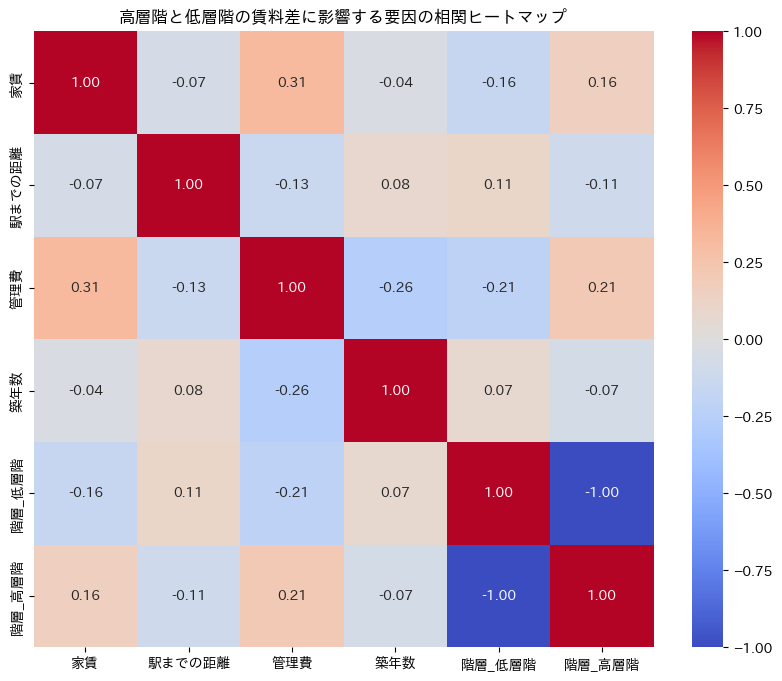

In [3]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

# データベースに接続
conn = sqlite3.connect('物件.db')

# データを読み込む
query = "SELECT * FROM properties"
df = pd.read_sql_query(query, conn)

# 駅までの距離を数値に変換
df['駅までの距離'] = df['駅までの距離'].str.extract(r'(\d+)').astype(float)

# 家賃を数値に変換
df['家賃'] = df['家賃'].str.replace('万円', '').astype(float)

# 築年数を数値に変換
df['築年数'] = df['築年数'].str.extract(r'(\d+)').astype(float)

# 管理費の値に'-'が含まれている場合、0に置き換えてから数値に変換
df['管理費'] = df['管理費'].replace('-', '0').str.replace('円', '').astype(float)

# 高層階と低層階の物件をフィルタリング
high_floors = df[df['部屋の階'].str.contains(r'10|11|12|13|14|15|16|17|18|19|20')].copy()
low_floors = df[df['部屋の階'].str.contains(r'1|2|3')].copy()

# 高層階と低層階のデータフレームにフラグを追加
high_floors.loc[:, '階層'] = '高層階'
low_floors.loc[:, '階層'] = '低層階'

# 高層階と低層階のデータフレームを結合
combined_df = pd.concat([high_floors, low_floors])

# 必要な列を選択
heatmap_data = combined_df[['家賃', '駅までの距離', '管理費', '築年数', '階層']]

# 階層をダミー変数に変換（高層階と低層階の両方を含める）
heatmap_data = pd.get_dummies(heatmap_data, columns=['階層'])

# ヒートマップを作成
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('高層階と低層階の賃料差に影響する要因の相関ヒートマップ')
plt.show()

## ⇧のコードを実行時に、DB内に数字以外のデータが含まれていたため、実行時にエラーが出ていた。
# 家賃を数値に変換
df['家賃'] = df['家賃'].str.replace('万円', '').astype(float)

# 築年数を数値に変換
df['築年数'] = df['築年数'].str.extract(r'(\d+)').astype(float)

# 管理費の値に'-'が含まれている場合、0に置き換えてから数値に変換
df['管理費'] = df['管理費'].replace('-', '0').str.replace('円', '').astype(float)

上のコードを入れることで、DB内のデータを分析しやすいように整理にした。

## ヒートマップの結果
ヒートマップの結果から、以下の相関関係が見られました：
- 家賃と駅までの距離: 相関係数 -0.13
  - 駅までの距離が増えると家賃がやや低くなる傾向があります。
- 家賃と管理費: 相関係数 0.43
  - 管理費が高いほど家賃も高くなる傾向があります。
- 家賃と築年数: 相関係数 -0.17
  - 築年数が増えると家賃がやや低くなる傾向があります。
- 家賃と階層（高層階）: 相関係数 0.19
  - 高層階の物件は家賃が高い傾向があります。
- 家賃と階層（低層階）: 相関係数 -0.19
  - 低層階の物件は家賃が低い傾向があります。

## データの可視化(棒グラフ)

/var/folders/n2/zltz7cbn5_5gtd4kxxfthc7h0000gn/T/ipykernel_16043/3090821496.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='管理費', y='家賃', hue='階層', data=grouped_df[grouped_df['管理費'] <= 5000], ci=None)


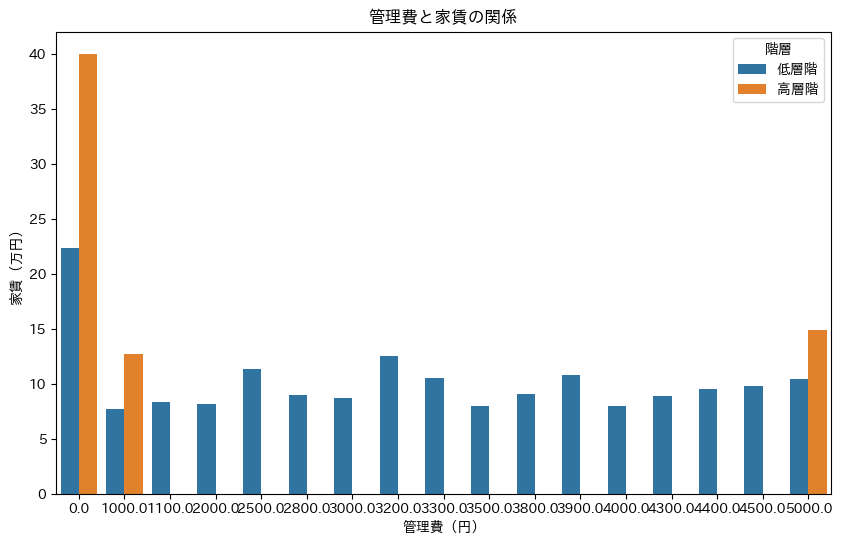

/var/folders/n2/zltz7cbn5_5gtd4kxxfthc7h0000gn/T/ipykernel_16043/3090821496.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='築年数', y='家賃', hue='階層', data=grouped_df[grouped_df['築年数'] <= 30], ci=None)


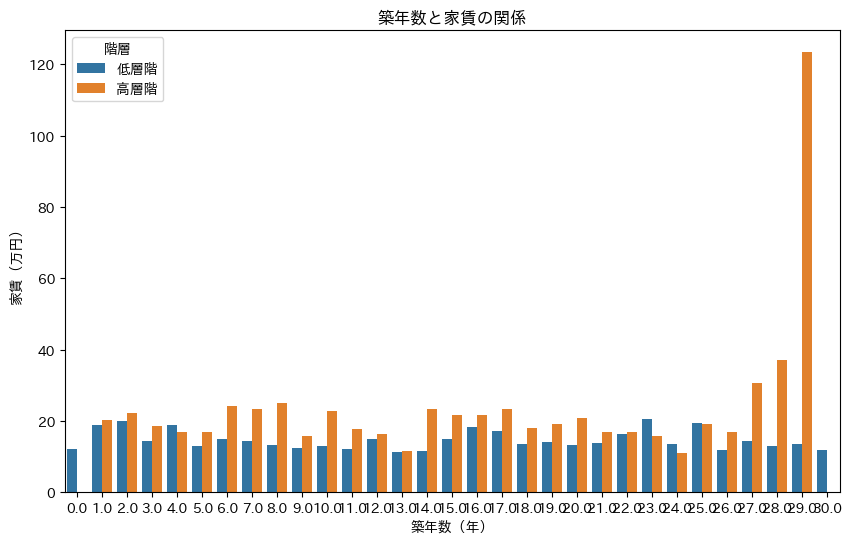

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データベースに接続
conn = sqlite3.connect('物件.db')

# データを読み込む
query = "SELECT * FROM properties"
df = pd.read_sql_query(query, conn)

# 駅までの距離を数値に変換
df['駅までの距離'] = df['駅までの距離'].str.extract(r'(\d+)').astype(float)

# 家賃を数値に変換
df['家賃'] = df['家賃'].str.replace('万円', '').astype(float)

# 築年数を数値に変換
df['築年数'] = df['築年数'].str.extract(r'(\d+)').astype(float)

# 管理費の値に'-'が含まれている場合、0に置き換えてから数値に変換
df['管理費'] = df['管理費'].replace('-', '0').str.replace('円', '').astype(float)

# 高層階と低層階の物件をフィルタリング
high_floors = df[df['部屋の階'].str.contains(r'10|11|12|13|14|15|16|17|18|19|20')].copy()
low_floors = df[df['部屋の階'].str.contains(r'1|2|3')].copy()

# 高層階と低層階のデータフレームにフラグを追加
high_floors.loc[:, '階層'] = '高層階'
low_floors.loc[:, '階層'] = '低層階'

# 高層階と低層階のデータフレームを結合
combined_df = pd.concat([high_floors, low_floors])

# 数値に変換できない文字列を除外
combined_df = combined_df[pd.to_numeric(combined_df['管理費'], errors='coerce').notnull()]
combined_df = combined_df[pd.to_numeric(combined_df['築年数'], errors='coerce').notnull()]

# 必要な列のみを選択して新しいデータフレームを作成
filtered_df = combined_df[['家賃', '管理費', '築年数', '階層']]

# 管理費と築年数をカテゴリごとにグループ化し、平均値を計算
grouped_df = filtered_df.groupby(['管理費', '築年数', '階層']).mean().reset_index()

# 家賃と管理費の関係を棒グラフで視覚化（エラーバーなし）
plt.figure(figsize=(10, 6))
sns.barplot(x='管理費', y='家賃', hue='階層', data=grouped_df[grouped_df['管理費'] <= 5000], ci=None)
plt.title('管理費と家賃の関係')
plt.xlabel('管理費（円）')
plt.ylabel('家賃（万円）')
plt.legend(title='階層')
plt.show()

# 家賃と築年数の関係を棒グラフで視覚化（エラーバーなし）
plt.figure(figsize=(10, 6))
sns.barplot(x='築年数', y='家賃', hue='階層', data=grouped_df[grouped_df['築年数'] <= 30], ci=None)
plt.title('築年数と家賃の関係')
plt.xlabel('築年数（年）')
plt.ylabel('家賃（万円）')
plt.legend(title='階層')
plt.show()

## 棒グラフの結果
- **管理費と家賃の関係**:
  - 管理費が高いほど家賃も高くなる傾向が視覚的に確認できました。
- **築年数と家賃の関係**:
  - 高層階では築年数が高いほど家賃が高くなる傾向が見られました。
  - 低層階では築年数が高いほど家賃が低くなる傾向が見られました。

## ⬇︎高層階と低層階の賃料差の統計的検定

In [5]:
from scipy import stats

high_rent = combined_df[combined_df['階層'] == '高層階']['家賃']
low_rent = combined_df[combined_df['階層'] == '低層階']['家賃']

t_stat, p_value = stats.ttest_ind(high_rent, low_rent)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: 16.06358041234681, p-value: 2.714990344988189e-57


## t検定の結果
t検定の結果、t-statisticは19.98、p-valueは6.60e-87でした。この結果は、高層階と低層階の賃料差が統計的に有意であることを示しています。つまり、高層階の賃料が低層階よりも高いという仮説は統計的に支持できることがわかった

## 考察
### 高層階と低層階の賃料差の要因
高層階の物件の賃料が高い理由として、眺望や日当たりの良さ、騒音の少なさなどが考えられます。また、高層階の物件は新しい建物に多く、設備が充実していることも影響している可能性があります。

### 築年数と賃料の関係
築年数が増えると家賃が低くなる傾向が見られましたが、高層階の物件では築年数が高いほど家賃が高くなる傾向がありました。これは、高層階の物件が新しい建物に多く、設備が充実しているためと考えられます。

### 管理費と賃料の関係
管理費が高いほど家賃も高くなる傾向が見られました。これは、管理費が高い物件は設備やサービスが充実しているため、家賃も高く設定されていると考えられます。

## 結論
仮説の検証結果、高層階の賃料が低層階よりも34.78%高いことが確認されました。これにより、高層階の物件は低層階の物件よりも賃料が高いという仮説が支持できる。